# Visualising San Francisco's Transit Lines and Stops

data source: 

* [SFMTA GTFS](https://www.sfmta.com/reports/gtfs-transit-data)

## Relevant Libraries

In [1]:
import pandas as pd
import mplleaflet
import shapely.geometry as sh
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame

%matplotlib inline

## Load in Data

In [2]:
'''
Read in relevant data files and prints all column names
'''
shapes = pd.read_csv('shapes.txt', sep=",", header=0)
routes = pd.read_csv('routes.txt', sep=",", header=0)
trips = pd.read_csv('trips.txt', sep=",", header=0)

print(shapes.columns.values.tolist())
print(routes.columns.values.tolist())
print(trips.columns.values.tolist())

['shape_id', 'shape_pt_lon', 'shape_pt_lat', 'shape_pt_sequence', 'shape_dist_traveled']
['route_id', 'agency_id', 'route_short_name', 'route_long_name', 'route_desc', 'route_type', 'route_url', 'route_color', 'route_text_color']
['route_id', 'service_id', 'trip_id', 'trip_headsign', 'direction_id', 'block_id', 'shape_id']


## Extract and Merge Required Data
"A route is a group of trips that are displayed to riders as a single service."

Shapes are "rules for drawing lines on a map to represent a transit organization's routes."

In [3]:
'''
The three tables are inner joined on the foreign keys route_id and shape_id.
The route_id uniquely identifies a route and shape_id uniquely identifies a shape.
'''
routes_trips = pd.merge(routes, trips, on='route_id', how='inner')
routes_trips_shapes = pd.merge(routes_trips, shapes, on='shape_id', how='inner')

In [4]:
'''
Using the list of column names, identify the columns that need to be retained.
Then remove the other columns as well as any duplicate rows.
'''
cols_retain = ['route_id',
    'shape_id',
    'shape_pt_lat',
    'shape_pt_lon',
    'shape_pt_sequence']

current_cols = routes_trips_shapes.columns.values
cols_to_drop = list(set(current_cols) - set(cols_retain))
routes_trips_shapes = routes_trips_shapes.drop(cols_to_drop, axis=1)
routes_trips_shapes = routes_trips_shapes.drop_duplicates()

## Create LineStrings from lat lon features

In [5]:
geometry = []
route = []

for route_id in routes_trips_shapes['route_id'].unique():
    shape_ids = set(routes_trips_shapes[routes_trips_shapes['route_id']== route_id]['shape_id'])
    for shape_id in shape_ids:
        multiline = sh.LineString(zip(shapes[shapes['shape_id']== shape_id]['shape_pt_lon'].tolist(),
                                  shapes[shapes['shape_id'] == shape_id]['shape_pt_lat'].tolist()))
        geometry.append(multiline)
        route.append(route_id)

In [6]:
lines_df = pd.DataFrame({
                        'route_id':route,
                        'geometry':geometry
                        })

## Merge back and convert to GeoDataFrame

In [7]:
routes_lines = pd.merge(lines_df, routes, on='route_id', how='left')

In [8]:
cols_retain = ['route_id',
               'agency_id',
               'route_short_name',
               'route_long_name',
               'route_type',
               'geometry'
              ]

current_cols = routes_lines.columns.values
cols_to_drop = list(set(current_cols) - set(cols_retain))
routes_lines = routes_lines.drop(cols_to_drop, axis=1)
routes_lines_gdf = GeoDataFrame(routes_lines, crs={'init': 'epsg:4326'}, geometry=routes_lines['geometry'])
routes_lines_gdf.head()

,geometry,route_id,agency_id,route_short_name,route_long_name,route_type
0,"LINESTRING (-122.396968 37.795436, -122.396784...",13392,SFMTA,1,CALIFORNIA,3
1,"LINESTRING (-122.396968 37.795436, -122.396784...",13392,SFMTA,1,CALIFORNIA,3
2,"LINESTRING (-122.446805 37.787266, -122.448481...",13392,SFMTA,1,CALIFORNIA,3
3,"LINESTRING (-122.446805 37.787266, -122.445415...",13392,SFMTA,1,CALIFORNIA,3
4,"LINESTRING (-122.493147 37.779708, -122.49331 ...",13392,SFMTA,1,CALIFORNIA,3


## Visualise data

Text(0.5,0.98,'Muni Lines in SF distinguished by route_type')

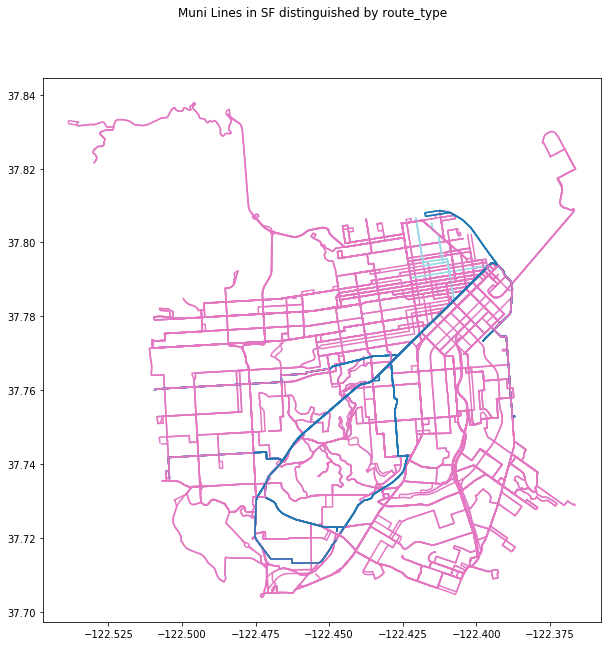

In [9]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = routes_lines_gdf.plot(ax=ax, column='route_type', cmap='tab20')
f.suptitle('Muni Lines in SF distinguished by route_type')

Text(0.5,0.98,'Muni Lines in SF distinguished by route_id')

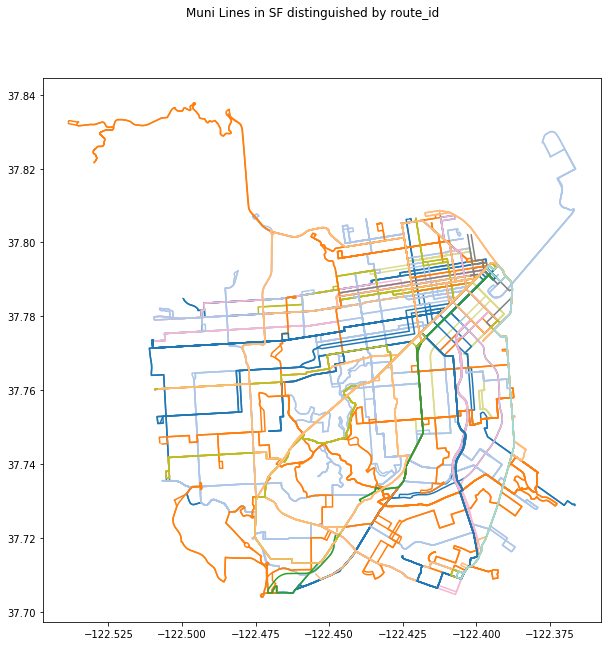

In [10]:
f, ax = plt.subplots(1, figsize=(10, 10))
ax = routes_lines_gdf.plot(ax=ax, column='route_id', cmap='tab20')
f.suptitle('Muni Lines in SF distinguished by route_id')

In [11]:
mplleaflet.display(fig=f, crs=routes_lines_gdf.crs, tiles='cartodb_positron')

## Reflections and Extensions

Overall, this was a quick and fun project to convert static GTFS data into a visualisation. It was a good way to bring together some skills from previous notebooks like mplleaflet, joining dataframes, and shapely. Having said that, this was a fairly quick and dirty visualisation and not only could the code be cleaner and tidier and better commented (will maybe update a cleaner version), but there are a number of key problems with the visualisation. These problems can mostly be identified in the image below. Firstly, the lines overlap one another, hiding routes that were drawn before the others. Secondly, the shapes occasionally end abruptly or break. Thirdly, the number of unique routes meant that color coding was not optimal for distinguishing the different routes. 

There is an array of extensions and fixes I am excited to get to in the future:
* Find a way to distinguish the different routes more easily.
* Identify and fix the problem of the abruptly ending lines.
* Avoid overlapping lines by drawing them side by side.
* Adding services supplied by BART
* Figuring out journey mapping between two points.

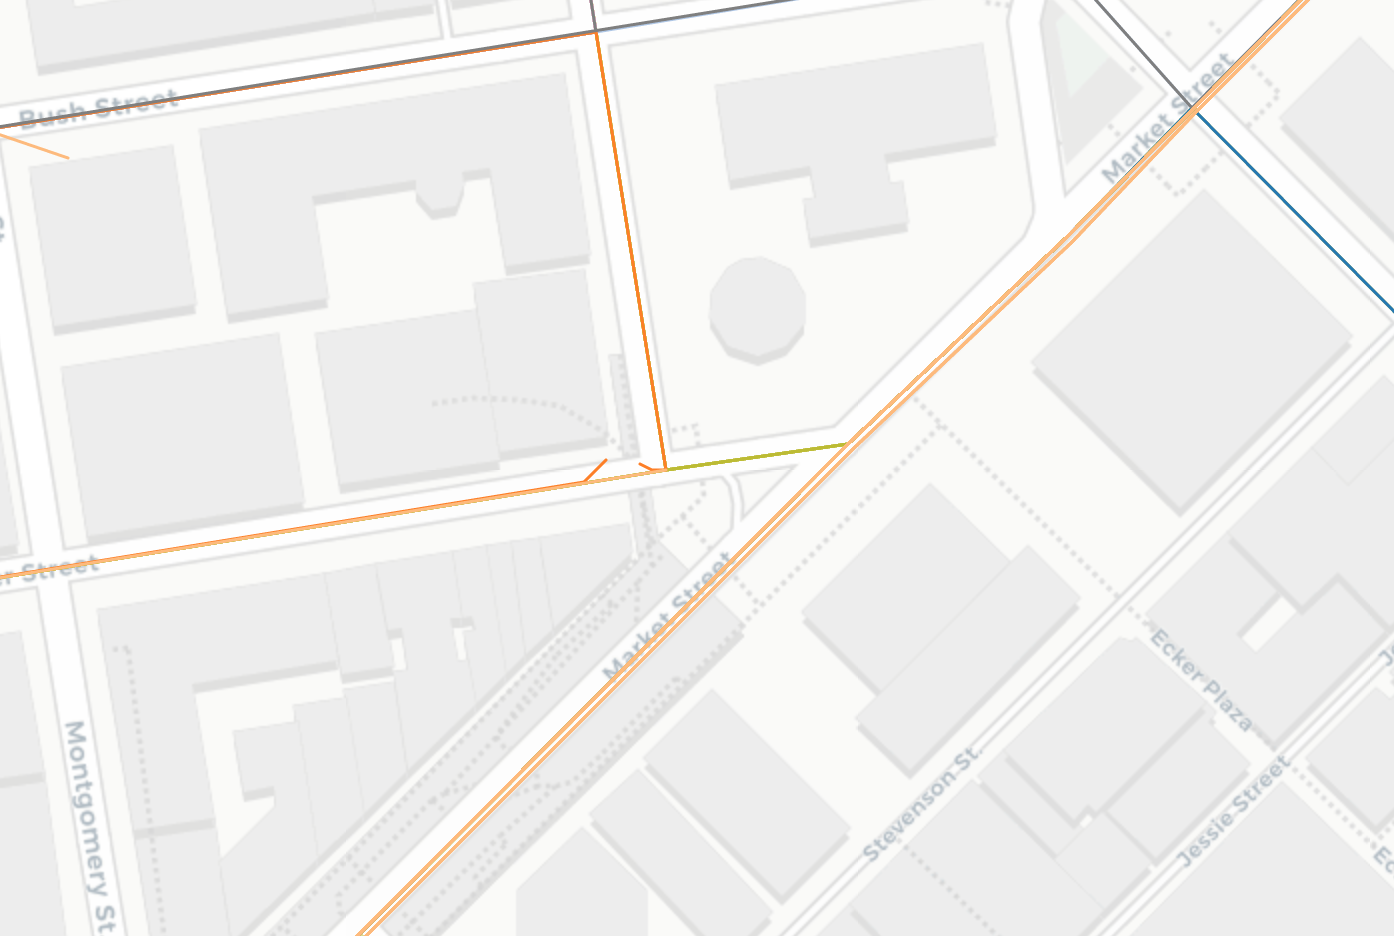

In [12]:
from IPython.display import Image
Image(filename='Confusions.png')